In [16]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/massil/repos


In [17]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.cup import CUP_algorithm
from algorithms.maxcosd_box import MaxCOSD_Box_algorithm
from simulator import Simulator

from tqdm import tqdm

### Defining the demand process
Here we define a perishable environment such that $n=1$, $T=2000$ and $d_t\sim \text{Poisson}(2)$, with newsvendor losses $\ell_t(y) = h(y-d_t)_+ + p (d_t-y)_+$.

Notice that in this example $\rho=1$.

In [18]:
nb_samples = 10
nb_products = 1
horizon = 10_000
holding_costs = np.ones(nb_products)
penalty_costs = 10*np.ones(nb_products)

np.random.seed(1)
envs = []
for sample_id in range(nb_samples) :
    demands = np.zeros((horizon+1,nb_products))
    demands[1:,:] = scipy.stats.poisson(1).rvs(size=(horizon, nb_products))
    envs.append(Environment_Perishable_Newsvendor(2, demands,holding_costs,penalty_costs))

### Defining the algorithms

The box constraint, the hyperparameter $\gamma\leq \rho/D$ and the gradients' norm upper bound $G$

In [19]:
y_min = 0*np.ones(nb_products)
y_max = 4*np.ones(nb_products)
#gamma = 1/np.sqrt(np.sum((y_max-y_min)*(y_max-y_min)))
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

The algorithms

In [20]:
initial_decision = np.zeros(nb_products)
list_gamma = [10**exponent for exponent in np.linspace(-5,1,9*6+1)]

algs = [CUP_algorithm(initial_decision, y_min,y_max, gamma, G) for gamma in list_gamma]
algs += [MaxCOSD_Box_algorithm(initial_decision,y_min,y_max,gamma) for gamma in list_gamma]
    
nb_algs = len(algs)

Building the simulator which wraps the main loop

In [21]:
horizons = np.linspace(10,horizon,100).astype(int)

sim = Simulator(envs, nb_products, nb_samples, horizons, algs,
    lambda optimum : ((optimum>=y_min).all() and (optimum<=y_max).all()), holding_costs,penalty_costs)
cum_losses = sim.run()

100%|██████████| 10/10 [12:08<00:00, 72.89s/it]


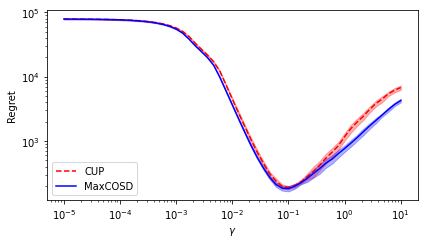

In [24]:
cup_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])
cup_std_regret = np.array([np.std(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])

cosd_mean_cum_losses = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])
cosd_std_cum_losses = np.array([np.std(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])

plt.figure(figsize=(6,3.5))
#plt.axhline(np.mean(cum_losses[:,0,-1]), color="black", linestyle="--", label="Comparator")

plt.loglog(list_gamma,cup_mean_regret, color="red", label="CUP",linestyle="--")
plt.fill_between(list_gamma, cup_mean_regret-cup_std_regret,cup_mean_regret+cup_std_regret, color="red", alpha=0.3)

plt.loglog(list_gamma,cosd_mean_cum_losses, color="blue", label="MaxCOSD")
plt.fill_between(list_gamma, cosd_mean_cum_losses-cosd_std_cum_losses,cosd_mean_cum_losses+cosd_std_cum_losses, color="blue", alpha=0.3)

#plt.axvline(gamma,linestyle="--",color="black")
plt.xlabel(r"$\gamma$")
plt.ylabel("Regret")
plt.legend(loc="lower left")
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig("images/perish_gamma_1.png", dpi=300)
plt.show()

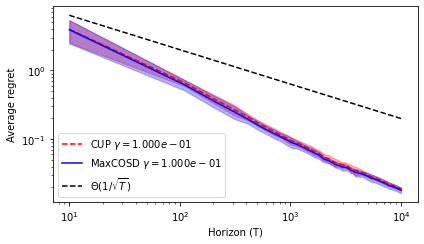

In [25]:
cup_gamma_index_opt = np.argmin(cum_losses[0,1:len(list_gamma)+1,-1])+1
cosd_gamma_index_opt = np.argmin(cum_losses[0,1*len(list_gamma)+1:2*len(list_gamma)+1,-1])+1*len(list_gamma)+1
colors = {cup_gamma_index_opt:"red", cosd_gamma_index_opt:"blue"}
linestyles = {cup_gamma_index_opt:"--", cosd_gamma_index_opt:"-"}

plt.figure(figsize=(6,3.5))

for i in [cup_gamma_index_opt, cosd_gamma_index_opt] :
    y = np.mean(cum_losses[:,i,:]-cum_losses[:,0,:],axis=0)
    std = np.std(cum_losses[:,i,:]-cum_losses[:,0,:],axis=0)
    plt.loglog(horizons, y/horizons,label=algs[i-1], color=colors[i], linestyle=linestyles[i])
    plt.fill_between(horizons, (y-std)/horizons,(y+std)/horizons, color=colors[i], alpha=0.3)
#plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.loglog(horizons,20/np.sqrt(horizons),"--",color="k",label=r"$\Theta(1/\sqrt{T})$")

plt.ylabel("Average regret")
plt.xlabel("Horizon (T)")
plt.legend(loc="lower left")
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig("images/perish_regret_1.png", dpi=300)
plt.show()